# Анализ результатов A/B-тестирования
Описание: у нас есть данные A/B-теста двух вариантов кнопки "Купить", в котором пользователи были случайным образом разделены на контрольную группу (control, старый дизайн) и тестовую группу (variant, новый дизайн).

Наша цель – выяснить, привел ли новый дизайн к увеличению дохода на пользователя (revenue).

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Загрузим и откроем сам датасет (взят с Kaggle):

In [36]:
file_path = 'ab-dataset/ab_results.csv'
df = pd.read_csv(file_path)

In [37]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [38]:
df.shape

(10000, 3)

Смотрим общую информацию о датасете:

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Проверяем на пропуски:

In [40]:
df.isnull().sum()

,0
USER_ID,0
VARIANT_NAME,0
REVENUE,0


In [41]:
print('Уникальных пользователей:', df['USER_ID'].nunique())
print('Всего записей:', len(df))

Уникальных пользователей: 6324
Всего записей: 10000


Чуть меньше 37% пользователей на данный момент дублируются.

Посмотрим на количество пользователей в обеих группах:

In [42]:
group_counts = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
users_with_multiple_groups = group_counts[group_counts > 1]
print('Пользователи с несколькими группами:', len(users_with_multiple_groups))

Пользователи с несколькими группами: 1541


In [43]:
len(users_with_multiple_groups) / df['USER_ID'].nunique() * 100

24.367488931056293

В каждой группе находится около 24% от общего числа пользователей - исключаем их данные из эксперимента, чтобы не получить искаженные результаты.

Поэтому рассматриваем только тех пользователей, которые состоят лишь в 1 группе:

In [44]:
users_with_one_group = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
users_with_one_group = users_with_one_group[users_with_one_group]
df = df[df['USER_ID'].isin(users_with_one_group.index)]
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


Теперь можно проанализировать распределение данных

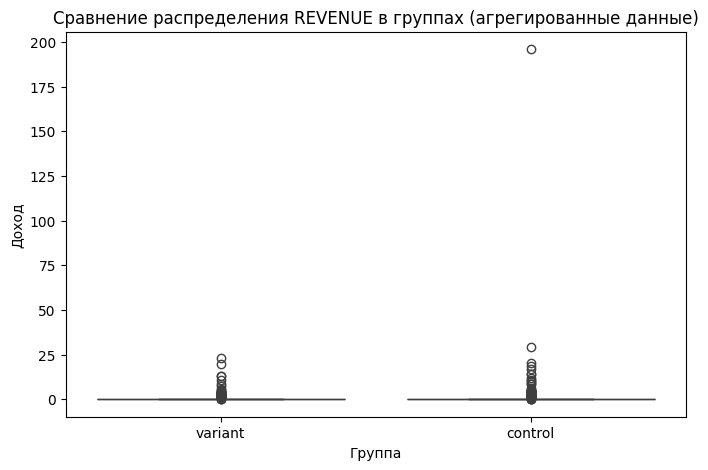

In [45]:
plt.figure(figsize=(8,5))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title('Сравнение распределения REVENUE в группах (агрегированные данные)')
plt.xlabel('Группа')
plt.ylabel('Доход')
plt.show()

Есть одно выбивающееся значение в группе control - посмотрим, единственное ли оно у данного пользователя, если да - можем просто удалить его из выборки

In [46]:
df.sort_values('REVENUE', ascending=False).head()

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [47]:
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


In [48]:
df = df[df['USER_ID'] != 3342]

Изучим подробнее полученные данные:

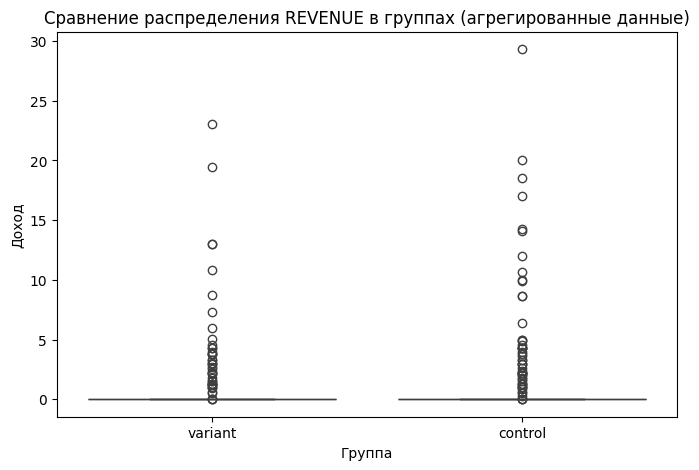

In [49]:
plt.figure(figsize=(8,5))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.title('Сравнение распределения REVENUE в группах (агрегированные данные)')
plt.xlabel('Группа')
plt.ylabel('Доход')
plt.show()

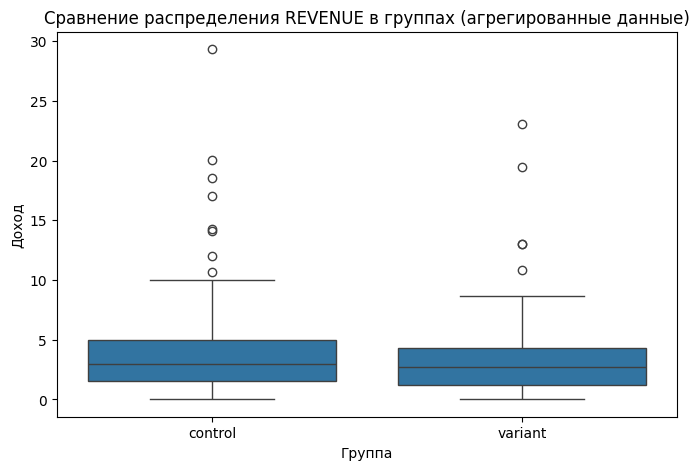

In [50]:
plt.figure(figsize=(8,5))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df[df['REVENUE'] > 0])
plt.title('Сравнение распределения REVENUE в группах (агрегированные данные)')
plt.xlabel('Группа')
plt.ylabel('Доход')
plt.show()

По графику заметно, что есть часть пользователей, у которых не было покупок (видимо, просто просмотр страницы)

Поскольку могут найтись пользователи, которые имеют и REVENUE = 0, и REVENUE > 0, объединим данные так, чтобы для каждого пользователя была одна запись, с суммарным REVENUE:

In [51]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False)['REVENUE'].sum()
df

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4777,9990,variant,0.0
4778,9992,control,0.0
4779,9993,control,0.0
4780,9995,variant,0.0


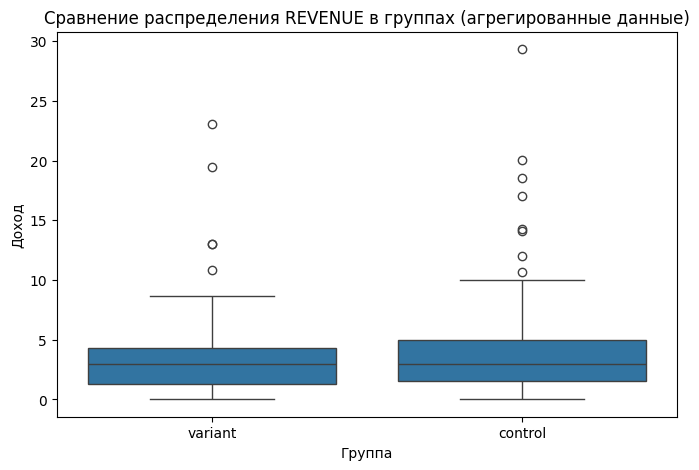

In [52]:
plt.figure(figsize=(8,5))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df[df['REVENUE'] > 0])
plt.title('Сравнение распределения REVENUE в группах (агрегированные данные)')
plt.xlabel('Группа')
plt.ylabel('Доход')
plt.show()

Отдельно посмотрим на средние статистики:

In [53]:
df.groupby('VARIANT_NAME')['REVENUE'].mean()

,REVENUE
VARIANT_NAME,
control,0.114923
variant,0.074935


In [54]:
df[df['REVENUE'] > 0].groupby('VARIANT_NAME')['REVENUE'].mean()

,REVENUE
VARIANT_NAME,
control,5.180189
variant,4.269524


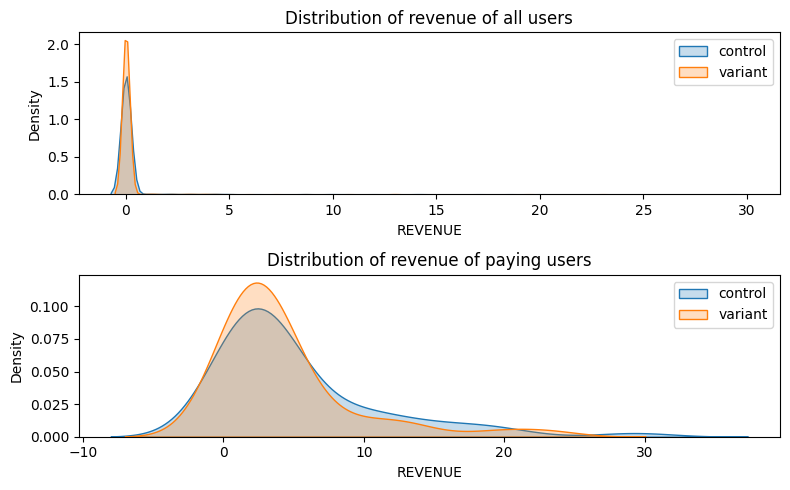

In [55]:
f, axes = plt.subplots(2, figsize=(8, 5))

sns.kdeplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax=axes[0], label='control', fill=True)
sns.kdeplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax=axes[0], label='variant', fill=True)
axes[0].set_title('Distribution of revenue of all users')
axes[0].legend()

sns.kdeplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax=axes[1], label='control', fill=True)
sns.kdeplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax=axes[1], label='variant', fill=True)
axes[1].set_title('Distribution of revenue of paying users')
axes[1].legend()

plt.tight_layout()
plt.show()


In [56]:
print('Доля платящих пользователей: ', df[df['REVENUE'] > 0]['USER_ID'].nunique() / df['USER_ID'].nunique())

Доля платящих пользователей:  0.01986616478460895


Видим, что большинство пользователей не оформляли заказы (а только заходили на страницу продукта, например)

Средние revenue выглядят схожими между контрольной и тестовой группами



По графикам выше видно, что распределение не является нормальным, это можно проверить с помощью таких методов, как QQ-plot или критерий Шапиро-Уилка (так как даже суммарно в двух группах наберется меньше 5000 записей):

Пусть

H0: данные имеют нормальное распределение

H1: данные не распределены нормально

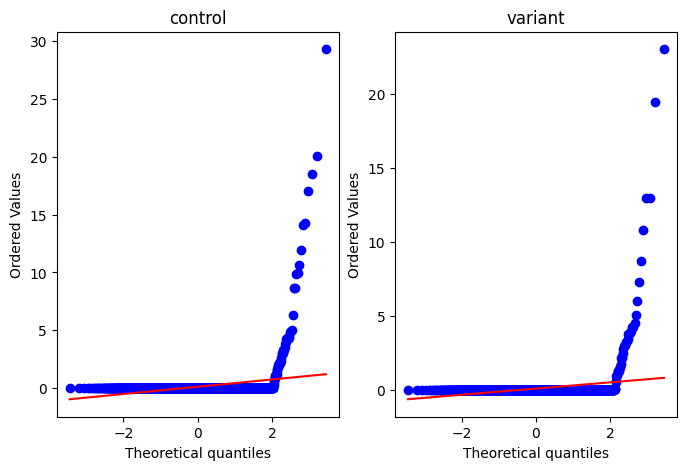

In [57]:
# QQ_plot
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
stats.probplot(df[df['VARIANT_NAME'] == 'control']['REVENUE'], plot=axes[0], dist='norm')
axes[0].set_title('control')
stats.probplot(df[df['VARIANT_NAME'] == 'variant']['REVENUE'], plot=axes[1], dist='norm')
axes[1].set_title('variant')
plt.show()

In [58]:
# Критерий Шапиро-Уилка
for variant in ['control', 'variant']:
    _, p_value = stats.shapiro(df[df['VARIANT_NAME'] == variant]['REVENUE'])
    print(f'p-value for {variant}: {p_value:.2f}')

p-value for control: 0.00
p-value for variant: 0.00


Отвергаем H0, следовательно, можно перейти к непараметрическому статистическому тесту Манна-Уитни:

Тогда относительно A/B-тестирования:

H0: Новый дизайн **не повлиял** на средний доход на пользователя

H1: Новый дизайн изменил средний доход на пользователя

In [59]:
stat_all, p_all = stats.mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'],
                               df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])
stat_paid, p_paid = stats.mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df['REVENUE'] > 0), 'REVENUE'],
                                 df.loc[(df.VARIANT_NAME == 'control') & (df['REVENUE'] > 0), 'REVENUE'])

print(f'p_all: {p_all}, p_paid: {p_paid}', '\n', p_all < 0.05, p_paid < 0.05)

p_all: 0.24799555106821947, p_paid: 0.5314192217084708 
 False False


**Вывод:**
Согласно результатам теста Манна-Уитни, в данном эксперименте не наблюдается статистически значимая разница между средними значениями двух групп => новый дизайн кнопки существенно не повлиял на доход с пользователя.